In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras

import os
from tqdm import tqdm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, Reshape, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
print(tf.__version__)
print(tf.test.is_gpu_available())

1.10.0
True


In [3]:
width = 256
height = 256
depth = 3
train_data_dir = "train/"
class_mode='categorical'
batch_size = 8
validation_split = 0.2
input_shape = (width, height, depth)
num_classes = len(next(os.walk(train_data_dir))[1])

# Data Augmentation and Training/Validation Splitting

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode = 'nearest', 
    zoom_range = 0.3,
    width_shift_range = 0.3, 
    height_shift_range = 0.3, 
    rotation_range=360,
    validation_split=validation_split)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    shuffle=True,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode=class_mode,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(width, height),
    batch_size=batch_size,
    class_mode=class_mode,
    subset='validation') # set as validation data

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


# Dealing with unbalanced dataset
The dataset is slightly unbalanced, so we will be using a weighted loss function and f1 score.

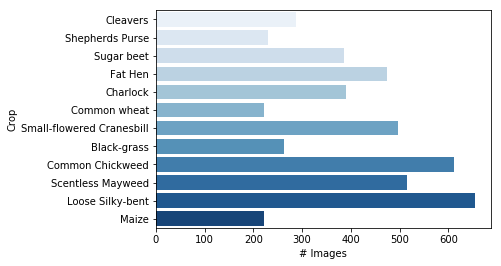

In [5]:
import glob
import seaborn as sns
from sklearn.utils import class_weight

content = []
for subdirectory in glob.glob('train/**/'):
    content.append([subdirectory.split('/')[1].split('/')[0], len(glob.glob(subdirectory+'*png'))])
data = pd.DataFrame(content, columns=['Crop', '# Images'])

# Plot Distribution Data By Crop
sns.barplot(x='# Images', y="Crop", data=data, palette="Blues");

class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)

# Build model - Simple CNN

In [6]:
drop_out_rate = 0.25

def get_model(input_shape, num_classes, drop_out_rate):

    cnn4 = Sequential()
    # 256
    cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    cnn4.add(BatchNormalization())

    cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(MaxPooling2D(pool_size=(2, 2)))
    cnn4.add(Dropout(drop_out_rate))

    cnn4.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(Dropout(drop_out_rate))

    cnn4.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(MaxPooling2D(pool_size=(2, 2)))
    cnn4.add(Dropout(drop_out_rate))
   
    cnn4.add(GlobalAveragePooling2D())

    cnn4.add(Dense(512, activation='relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(Dropout(drop_out_rate))

    cnn4.add(Dense(128, activation='relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(Dropout(drop_out_rate))

    cnn4.add(Dense(num_classes, activation='softmax'))
    
    return cnn4

model = get_model(input_shape=input_shape, num_classes=num_classes, drop_out_rate=drop_out_rate)

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 254, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 252, 252, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 64)      18496     
__________

In [8]:
from generic.deep_learning_tools.performance_metrics import EvaluationMetrics

model.compile(loss =keras.losses.categorical_crossentropy, optimizer ='Adam', metrics=[EvaluationMetrics().f1])

callbacks = [ReduceLROnPlateau(), EarlyStopping(monitor='val_loss', patience=25), ModelCheckpoint(filepath='cnn4.h5', monitor='val_loss', save_best_only=True)]

Using TensorFlow backend.


# Training

epochs = 100
history = model.fit_generator(train_generator,
          validation_data=validation_generator,
          epochs=epochs,
          verbose=1,
          shuffle=True,
          callbacks=callbacks)